# Import Modules and Settings

In [32]:
import os
import path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, StratifiedKFold, learning_curve, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, auc, fbeta_score, make_scorer
fbeta2_scorer = make_scorer(fbeta_score, beta = 2)
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)

random_state = 98924

import path
spotify_data = 'spotify_analysis.pickle'
album_data = 'spotify_album_analysis.pickle'
album_data_v2 = 'album_df_additional_genre_cleaning'

path = os.getcwd() + '/data/'
raw_path = path + 'raw/'
billboard_path = path + 'external/billboard_weeks/'
fuzzy_path = path + 'interim/'
model_path = path + 'model/'

### Problem

**Using the Spotipy package, I'm extracting a set of 'audio features' that are provided by Spotify's Web API in order to predict if a song will be 'successful'.**  

**Use**: In today's digital age the barrier to releasing songs has become almost trivial, but this has also led to an exponential increase in the 'noise'. One of the largest entries to barriers in into the music industry is getting noticed. Although it's no guarantee of sustained success, being able to produce a top 'hit' goes a long way towards getting your foot in the door. By using Spotify's audio features to create a model, I will provide recommendations to upcoming producers on features to focus on that will most likely get their songs noticed. 

### Variable Descriptions

**Description of features as provided by Spotify. Any features on a continuous scale from 0-1 were multiplied by 100 to provide easier readability.**   
* **acousticness**: a confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.  
* **danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.  
* **energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
* **instrumentalness**: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
* **key**: The key the track is in. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on.
* **liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
* **loudness**: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.
* **mode**: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
* **speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
* **tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
* **valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

# Exploratory Data Analysis

In [2]:
spotify_df = pd.read_pickle(model_path + album_data)

In [45]:
features = ['danceability', 'energy', 'loudness', 'tempo','instrumentalness','key','liveness','mode','valence', 'acousticness', 'pop',
            'rap', 'hip-hop', 'country', 'electronic', 'rock','indie', 'house', 'metal', 'jazz', 'soul', 'reggaeton', 'other', 'minutes']

plotting_features = ['success','danceability', 'energy', 'loudness', 'tempo', 'valence', 'instrumentalness', 
                     'key', 'liveness', 'acousticness']
y = spotify_df['success']
X = spotify_df.loc[:,features]
X = X.astype('float64')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, 
                                                    random_state = random_state,
                                                    stratify = y)

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = .25,
                                            random_state = random_state,
                                            stratify = y_train)

### Basic EDA Visualizations

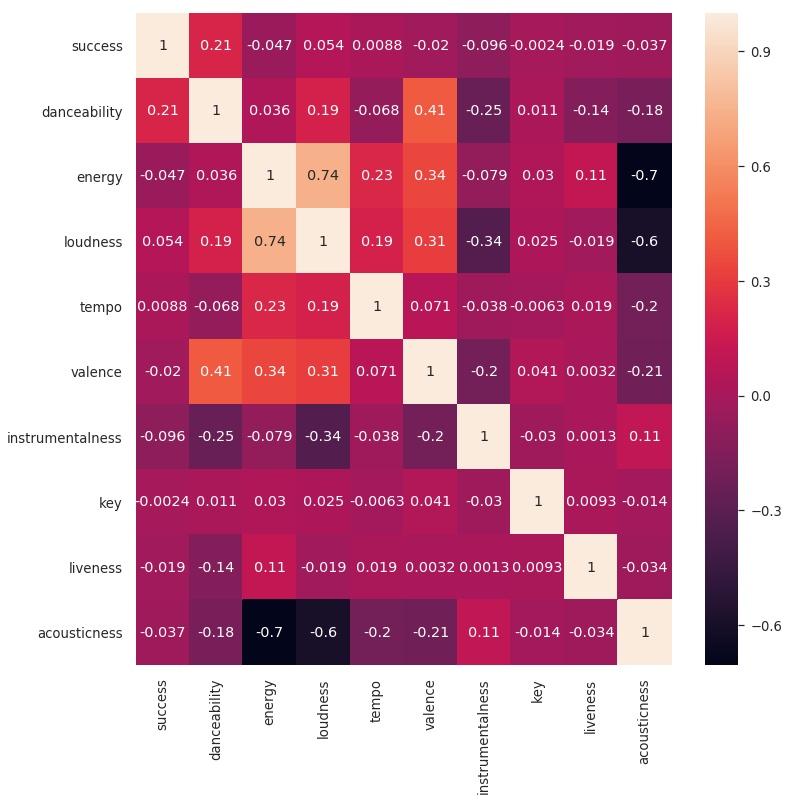

In [29]:
plt.figure(figsize = (12,12))
sns.set(context="notebook", style="darkgrid", rc={"figure.facecolor":"white"}, font_scale= 1.2)
sns.heatmap(spotify_df[plotting_features].corr(), annot = True)

/home/jc98924/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/jc98924/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


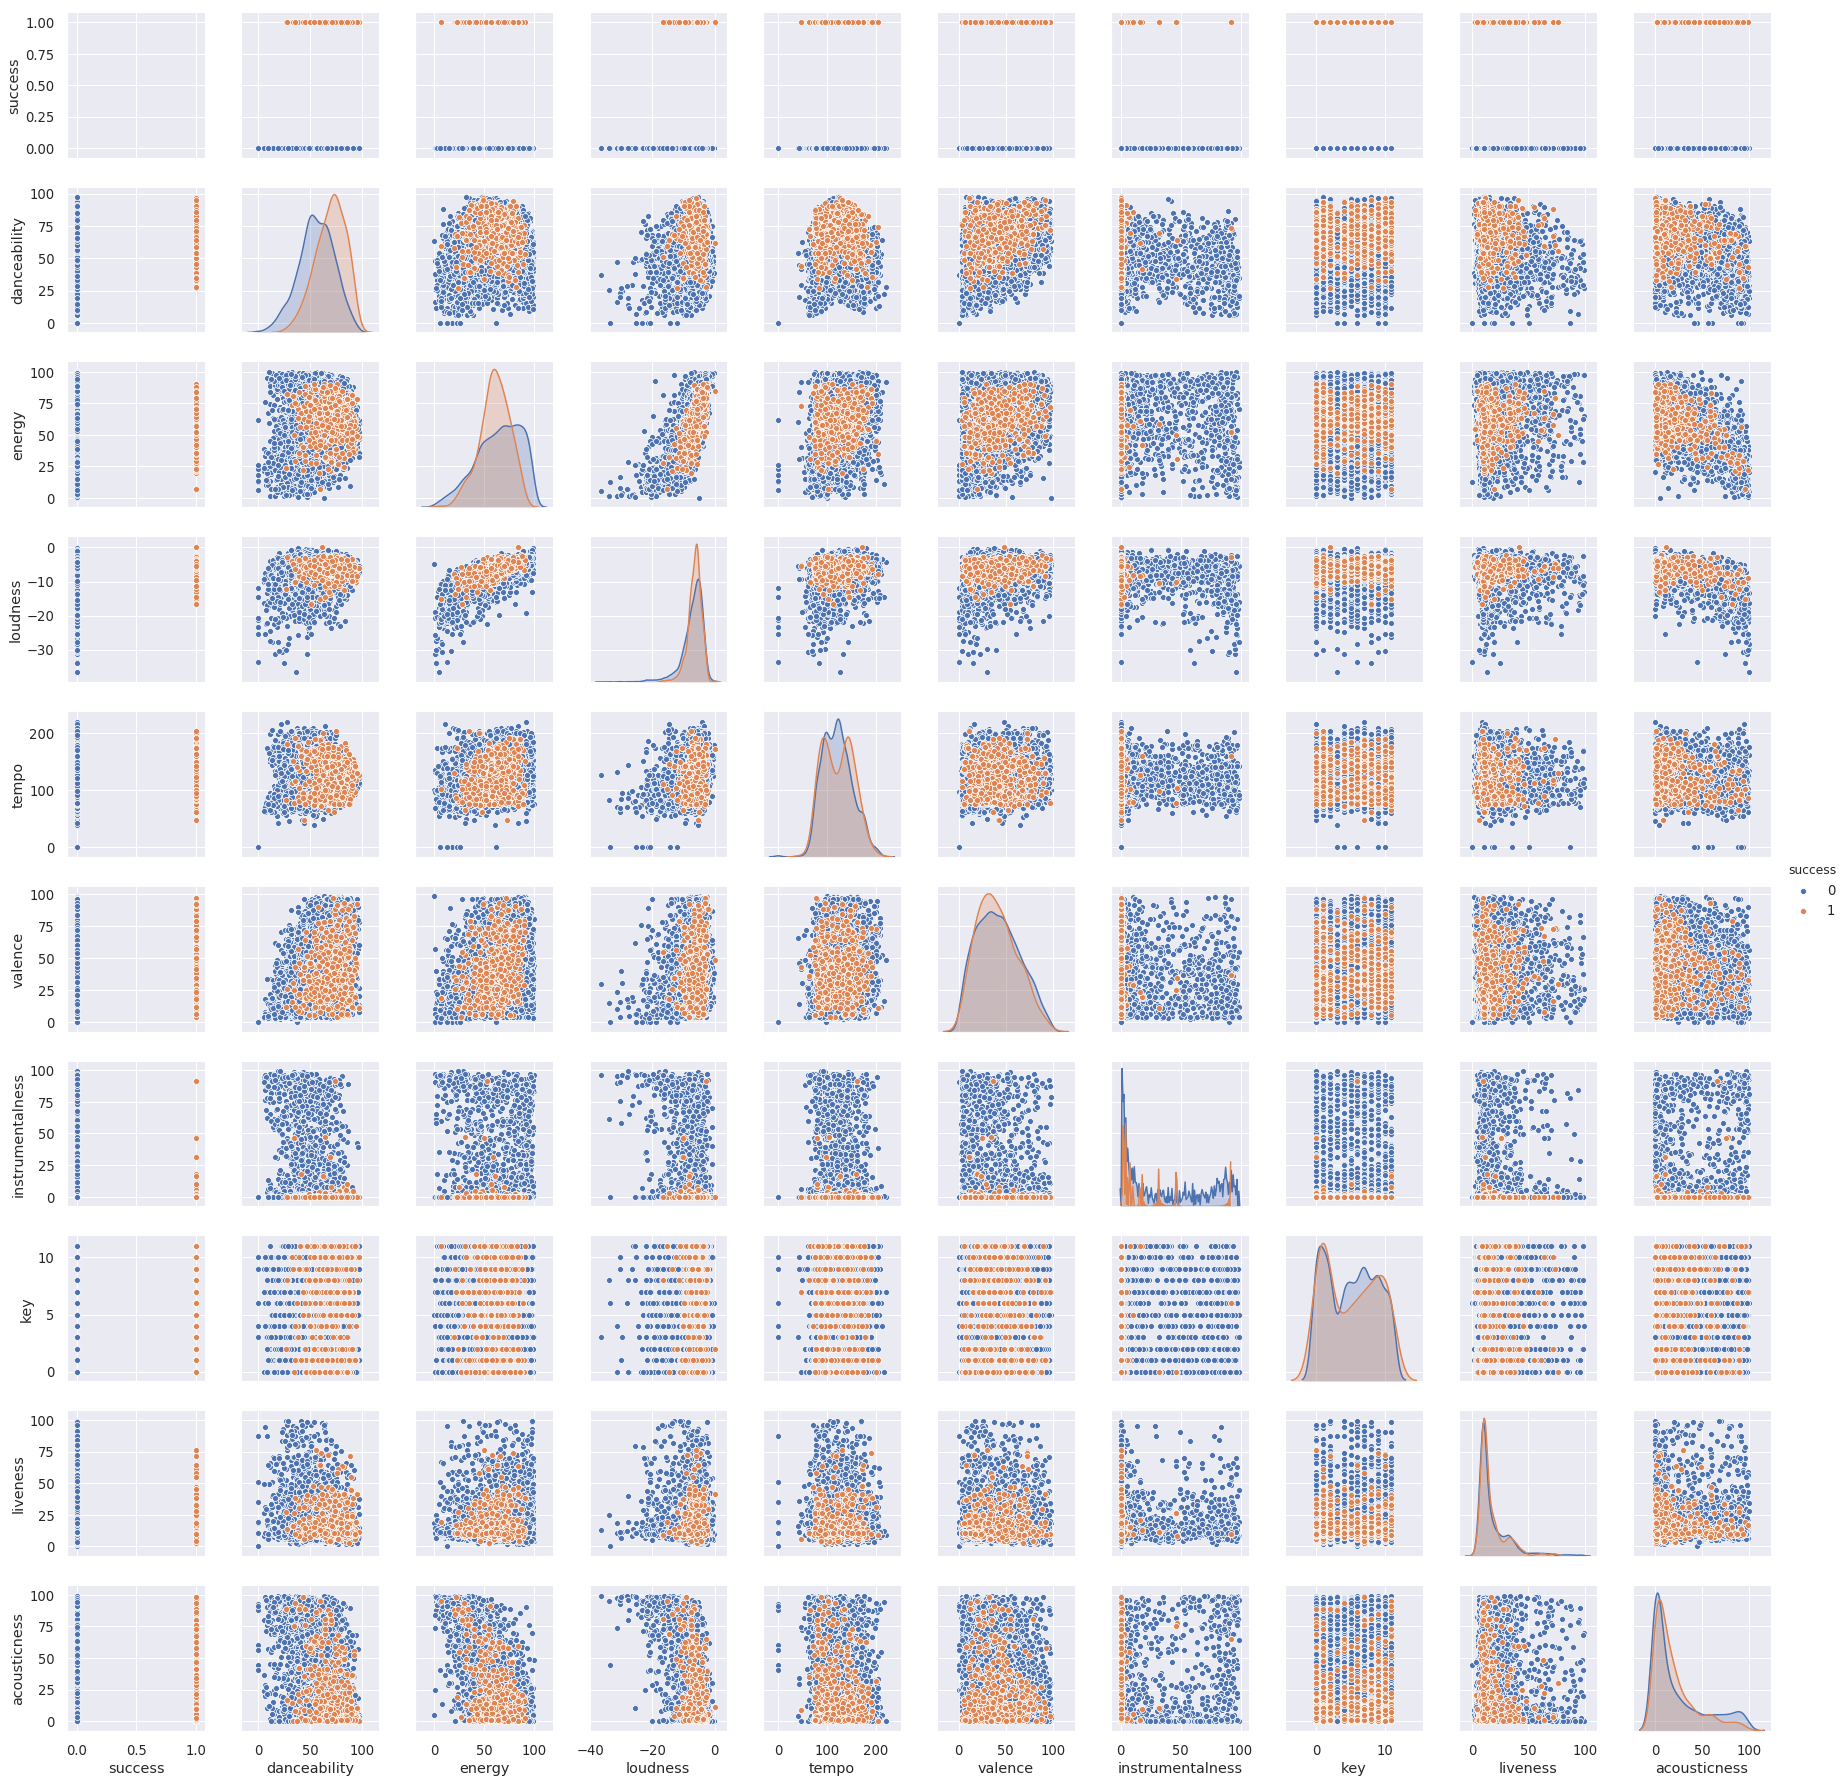

In [30]:
sns.pairplot(spotify_df[plotting_features], hue = 'success')

# Modeling

### Logistic Regression

In [10]:
# Logistic Regression with parameter tuning
pipe = Pipeline([
    ('scalar', StandardScaler()),
    ('clf', LogisticRegression())
])

skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 5)

parameters =  {
    'clf__C': [0.001, 0.01, .05, 0.1, 0.5, 1, 10, 100, 1000],
    'clf__class_weight': [{1:2, 0:1}, {1:3, 0:1},
                          {1:4, 0:1}, {1:5, 0:1},
                          {1:6, 0:1}, {1:7, 0:1},
                          'balanced']
}

grid = GridSearchCV(pipe, param_grid = parameters, cv = skf, scoring = fbeta2_scorer, return_train_score = True)
grid.fit(X_tr, y_tr)
grid_scores = grid.score(X_val, y_val)
grid_y_predict = pd.Series(grid.predict(X_test))
print('F-Beta Score:', grid_scores, '\n')

print('Optimal Parameters:')
print(grid.best_params_,'\n')
print(grid.scorer_,'\n')

print('Precision : {:4.6f}'.format(precision_score(y_test, grid_y_predict)))
print('Recall    : {:4.6f}'.format(recall_score(y_test, grid_y_predict)))


F-Beta Score: 0.5700934579439252 

Optimal Parameters:
{'clf__C': 0.1, 'clf__class_weight': {1: 6, 0: 1}} 

Precision : 0.293839
Recall    : 0.765432


### Decision Tree Classifier

In [ ]:
tree_clf = DecisionTreeClassifier(random_state = 5)

skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 5)

parameters =  {
    'criterion': ['gini','entropy'],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'class_weight': [{0:1, 1:4}, {0:1, 1:5}, {0:1, 1:6}, {0:1, 1:7}],
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]
}

grid = RandomizedSearchCV(tree_clf, param_distributions = parameters, cv = skf, 
                          scoring = fbeta2_scorer, random_state = 5)


grid.fit(X_train, y_train)
grid_scores = grid.score(X_test, y_test)
grid_y_predict = grid.predict(X_test)

print('F-Beta Score:', grid_scores, '\n')

print('Optimal Parameters:')
print(grid.best_params_,'\n')

print('Precision : {:4.6f}'.format(precision_score(y_test, grid_y_predict)))
print('Recall    : {:4.6f}'.format(recall_score(y_test, grid_y_predict)))

### RandomForest Classifier 

In [72]:
forest_clf = RandomForestClassifier(random_state = 5)

skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 5)

parameters =  {
    'n_estimators': [300, 400, 500],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'class_weight': [{0:1, 1:4}, {0:1, 1:5}, {0:1, 1:6}, {0:1, 1:7}],
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]
}

grid = RandomizedSearchCV(forest_clf, param_distributions = parameters, cv = skf, 
                          scoring = fbeta2_scorer, random_state = 5)
grid.fit(X_train, y_train)
grid_y_predict = grid.predict(X_test)
print(grid.score(X_test, y_test))

print('Optimal Parameters:')
print(grid.best_params_,'\n')
print('Precision : {:4.6f}'.format(precision_score(y_test, grid_y_predict)))
print('Recall    : {:4.6f}'.format(recall_score(y_test, grid_y_predict)))

0.5976095617529881
Optimal Parameters:
{'n_estimators': 300, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 5, 'class_weight': {0: 1, 1: 7}} 

Precision : 0.337079
Recall    : 0.740741


### Extra Tree

In [ ]:
extra_tree_clf = ExtraTreeClassifier(random_state = 5)

skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 5)

parameters =  {
    'criterion': ['gini','entropy'],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'class_weight': [{0:1, 1:4}, {0:1, 1:5}, {0:1, 1:6}, {0:1, 1:7}],
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]
}

grid = RandomizedSearchCV(extra_tree_clf, param_distributions = parameters, cv = skf, 
                          scoring = fbeta2_scorer, random_state = 5)


grid.fit(X_train, y_train)
grid_scores = grid.score(X_test, y_test)
grid_y_predict = grid.predict(X_test)

print('F-Beta Score:', grid_scores, '\n')

print('Optimal Parameters:')
print(grid.best_params_,'\n')

print('Precision : {:4.6f}'.format(precision_score(y_test, grid_y_predict)))
print('Recall    : {:4.6f}'.format(recall_score(y_test, grid_y_predict)))

### XGBoost

In [47]:
xg_clf = XGBClassifier(n_estimators = 400, scale_pos_weight = 6, learning_rate = .0001, max_depth = 8,
                   random_state = 5, booster = 'dart')
xg_clf.fit(X_tr, y_tr)
xg_y_tr_predict = xg_clf.predict(X_tr)
xg_y_val_predict = xg_clf.predict(X_val)

print('Training Set:')
print('Accuracy  : {:4.6f}'.format(accuracy_score(y_tr, xg_y_tr_predict)))
print('Precision : {:4.6f}'.format(precision_score(y_tr, xg_y_tr_predict)))
print('Recall    : {:4.6f}'.format(recall_score(y_tr, xg_y_tr_predict)))
print('F1 Score  : {:4.6f}'.format(f1_score(y_tr, xg_y_tr_predict)))
print('FB Score  : {:4.6f}'.format(fbeta_score(y_tr, xg_y_tr_predict, average = 'binary', beta = 2)), '\n') 

print('Validation Set:')
print('Accuracy  : {:4.6f}'.format(accuracy_score(y_val, xg_y_val_predict)))
print('Precision : {:4.6f}'.format(precision_score(y_val, xg_y_val_predict)))
print('Recall    : {:4.6f}'.format(recall_score(y_val, xg_y_val_predict)))
print('F1 Score  : {:4.6f}'.format(f1_score(y_val, xg_y_val_predict)))
print('FB Score  : {:4.6f}'.format(fbeta_score(y_val, xg_y_val_predict, average = 'binary', beta = 2)), '\n')

Training Set:
Accuracy  : 0.873570
Precision : 0.347505
Recall    : 0.770492
F1 Score  : 0.478981
FB Score  : 0.619644 

Validation Set:
Accuracy  : 0.857275
Precision : 0.304348
Recall    : 0.682927
F1 Score  : 0.421053
FB Score  : 0.546875 



In [48]:
xg_y_te_pre = xg.predict(X_test)

print('Extra Tree Test Set:')
print('Accuracy  : {:4.6f}'.format(accuracy_score(y_test, xg_y_te_pre)))
print('Precision : {:4.6f}'.format(precision_score(y_test, xg_y_te_pre)))
print('Recall    : {:4.6f}'.format(recall_score(y_test, xg_y_te_pre)))
print('F1 Score  : {:4.6f}'.format(f1_score(y_test, xg_y_te_pre)))
print('FB Score  : {:4.6f}'.format(fbeta_score(y_test, xg_y_te_pre, average = 'binary', beta = 2)), '\n')

Extra Tree Test Set:
Accuracy  : 0.868397
Precision : 0.331492
Recall    : 0.740741
F1 Score  : 0.458015
FB Score  : 0.594059 



### Gaussian Naive Bayes

In [54]:
gnb = GaussianNB()
gnb.fit(X_tr, y_tr)
gnb_y_tr_predict = gnb.predict(X_tr)
gnb_y_val_predict = gnb.predict(X_val)

print('Gaussian Naive Bayes Training Set:')
print('Accuracy  : {:4.6f}'.format(accuracy_score(y_tr, gnb_y_tr_predict)))
print('Precision : {:4.6f}'.format(precision_score(y_tr, gnb_y_tr_predict)))
print('Recall    : {:4.6f}'.format(recall_score(y_tr, gnb_y_tr_predict)))
print('F1 Score  : {:4.6f}'.format(f1_score(y_tr, gnb_y_tr_predict)))
print('FB Score  : {:4.6f}'.format(fbeta_score(y_tr, gnb_y_tr_predict, average = 'binary', beta = 2)), '\n')

print('Gaussian Naive Bayes Validation Set:')
print('Accuracy  : {:4.6f}'.format(accuracy_score(y_val, gnb_y_val_predict)))
print('Precision : {:4.6f}'.format(precision_score(y_val, gnb_y_val_predict)))
print('Recall    : {:4.6f}'.format(recall_score(y_val, gnb_y_val_predict)))
print('F1 Score  : {:4.6f}'.format(f1_score(y_val, gnb_y_val_predict)))
print('FB Score  : {:4.6f}'.format(fbeta_score(y_val, gnb_y_val_predict, average = 'binary', beta = 2)), '\n')

Gaussian Naive Bayes Training Set:
Accuracy  : 0.553941
Precision : 0.141662
Recall    : 0.971311
F1 Score  : 0.247261
FB Score  : 0.447339 

Gaussian Naive Bayes Validation Set:
Accuracy  : 0.531974
Precision : 0.133449
Recall    : 0.939024
F1 Score  : 0.233687
FB Score  : 0.425414 



# Final Model Tuning

In [64]:
forest = RandomForestClassifier(n_estimators = 300, max_features = 'auto', 
                                min_samples_leaf = 3, class_weight = {0:1, 1:6},  
                                max_depth = 6, min_samples_split = 5, random_state = 5 )

forest.fit(X_tr, y_tr)
forest_y_tr_predict = forest.predict(X_tr)
forest_y_val_predict = forest.predict(X_val)

forest_probs_val = forest.predict_proba(X_val)[:,1]

print('Training Set:')
print('Accuracy  : {:4.6f}'.format(accuracy_score(y_tr, forest_y_tr_predict)))
print('Precision : {:4.6f}'.format(precision_score(y_tr, forest_y_tr_predict)))
print('Recall    : {:4.6f}'.format(recall_score(y_tr, forest_y_tr_predict)))
print('F1 Score  : {:4.6f}'.format(f1_score(y_tr, forest_y_tr_predict)))
print('FB Score  : {:4.6f}'.format(fbeta_score(y_tr, forest_y_tr_predict, average = 'binary', beta = 2)),'\n') 

print('Validation Set:')
print('Accuracy  : {:4.6f}'.format(accuracy_score(y_val, forest_y_val_predict)))
print('Precision : {:4.6f}'.format(precision_score(y_val, forest_y_val_predict)))
print('Recall    : {:4.6f}'.format(recall_score(y_val, forest_y_val_predict)))
print('F1 Score  : {:4.6f}'.format(f1_score(y_val, forest_y_val_predict)))
print('FB Score  : {:4.6f}'.format(fbeta_score(y_val, forest_y_val_predict, average = 'binary', beta = 2))) 

Training Set:
Accuracy  : 0.878207
Precision : 0.348178
Recall    : 0.704918
F1 Score  : 0.466125
FB Score  : 0.585034 

Validation Set:
Accuracy  : 0.873031
Precision : 0.331288
Recall    : 0.658537
F1 Score  : 0.440816
FB Score  : 0.549898


In [56]:
# Scoring on hold-out/test set
forest_y_test_predict = forest.predict(X_test)
print('Test Set:')
print('Accuracy  : {:4.6f}'.format(accuracy_score(y_test, forest_y_test_predict)))
print('Precision : {:4.6f}'.format(precision_score(y_test, forest_y_test_predict)))
print('Recall    : {:4.6f}'.format(recall_score(y_test, forest_y_test_predict)))
print('F1 Score  : {:4.6f}'.format(f1_score(y_test, forest_y_test_predict)))
print('FB Score  : {:4.6f}'.format(fbeta_score(y_test, forest_y_test_predict, average = 'binary', beta = 2)))

Test Set:
Accuracy  : 0.876738
Precision : 0.345238
Recall    : 0.716049
F1 Score  : 0.465863
FB Score  : 0.589431


In [65]:
# Scoring on hold-out/test set
forest_y_test_predict = forest.predict(X_test)
print('Test Set:')
print('Accuracy  : {:4.6f}'.format(accuracy_score(y_test, forest_y_test_predict)))
print('Precision : {:4.6f}'.format(precision_score(y_test, forest_y_test_predict)))
print('Recall    : {:4.6f}'.format(recall_score(y_test, forest_y_test_predict)))
print('F1 Score  : {:4.6f}'.format(f1_score(y_test, forest_y_test_predict)))
print('FB Score  : {:4.6f}'.format(fbeta_score(y_test, forest_y_test_predict, average = 'binary', beta = 2))) 

Test Set:
Accuracy  : 0.886932
Precision : 0.367742
Recall    : 0.703704
F1 Score  : 0.483051
FB Score  : 0.594990


In [66]:
pd.DataFrame({'Variable': X_tr.columns,
              'Importance': forest.feature_importances_}).sort_values('Importance', ascending = False).head(11)

,Variable,Importance
11,rap,0.250
0,danceability,0.113
12,hip-hop,0.101
15,rock,0.091
4,instrumentalness,0.084
1,energy,0.059
9,acousticness,0.043
23,minutes,0.039
16,indie,0.039
2,loudness,0.037


Text(23.0, 0.5, 'Actual')

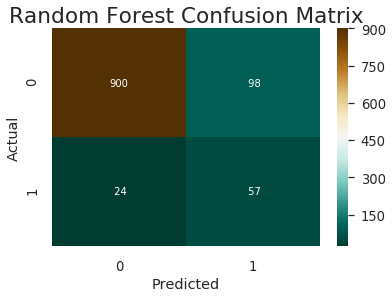

In [67]:
sns.heatmap(confusion_matrix(y_test, forest_y_test_predict), cmap = 'BrBG_r', annot = True, fmt = '3g')
sns.set(context="talk", style="darkgrid", rc={"figure.facecolor":"white"}, font_scale= 1.2)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')